In [ ]:
# Adapted from:
#\https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
#https://www.programmersought.com/article/31037125394/

In [1]:
pip install transformers

     |████████████████████████████████| 2.1MB 5.4MB/s 
     |████████████████████████████████| 3.3MB 18.1MB/s 
     |████████████████████████████████| 901kB 38.4MB/s 


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import time
from sklearn.metrics import classification_report
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#df_all = pd.read_csv('all-data.csv',encoding='latin-1')
df_all = pd.read_csv('/content/drive/My Drive/content/all-data.csv', encoding = 'latin-1', header=None )
df_all.columns = ["sentiment", "text"]

In [4]:
df_all.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
#df_all = df_all[['text','sentiment']]
dic = {'negative' : 0, 'neutral': 1, 'positive': 2}
df_all['sentiment']= df_all['sentiment'].replace(dic).astype('int64')
df_all.head()

,sentiment,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [6]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df_all['text'], df_all['sentiment'], 
                                                                    random_state=45, 
                                                                    test_size=0.3, 
                                                                    stratify=df_all['sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=45, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [7]:
from transformers import AutoModel, BertTokenizerFast
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [8]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

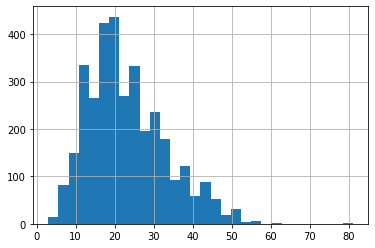

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

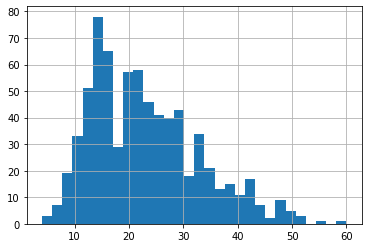

In [10]:
# get length of all the messages in the val set
seq_len = [len(i.split()) for i in val_text]
pd.Series(seq_len).hist(bins = 30)

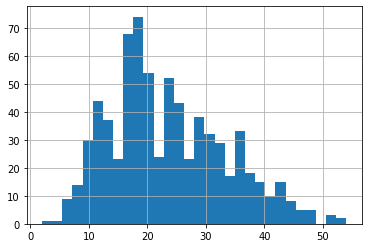

In [11]:
# get length of all the messages in the test set
seq_len = [len(i.split()) for i in test_text]
pd.Series(seq_len).hist(bins = 30)

In [12]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 40,
    padding='longest',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 40,
    padding='longest',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 40,
    padding='longest',
    truncation=True
)

In [13]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [14]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, drop_last=True)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size, drop_last=True)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size, drop_last=True)

In [15]:

#print('train loader',len(train_dataloader.dataset))
#print('val loader',len(val_dataloader.dataset))
#print('test loader',len(test_loader))

In [16]:
#import torch.nn as nn
#import torch.nn.functional as F
from torch.autograd import Variable


class AttnDPCNN(nn.Module):

    def __init__(self, batch_size,seq_len,embedding_dim,output_size_linear, 
                 cnn_channel_size, cnn_kernel_size=(3,1),cnn_padding=0, cnn_stride=1, attn_nodes_per_layer = 10):

        super(AttnDPCNN, self).__init__()
        #self.bert=bert
        self.attn_nodes_per_layer = attn_nodes_per_layer
        self.channel_size = cnn_channel_size
        self.output_size_linear = output_size_linear
        self.cnn_kernel_size = cnn_kernel_size
        self.padding = cnn_padding
        self.stride = cnn_stride
        #self.vocab_size = vocab_size
        self.embed_dim = embedding_dim
        self.seq_len = seq_len
        self.batch_size = batch_size
        
        #self.collect_out_softmax = torch.zeros(1,1).to(device)
        #self.collect_out_attn = torch.zeros(self.batch_size,self.attn_nodes_per_layer).to(device)
        
        #self.embed = nn.Embedding(self.vocab_size, self.embed_dim)
        self.conv1 = nn.Conv2d(1,  self.channel_size, (3,self.embed_dim), stride = 1) # embed_dim becomes 1
        self.conv2 = nn.Conv2d(self.channel_size,  self.channel_size,  
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride)
        self.padding1 = nn.ZeroPad2d((0, 0, 1, 1))  # top bottom
        self.padding2 = nn.ZeroPad2d((0, 0, 0, 1))  # bottom
        self.max_pool = nn.MaxPool2d(kernel_size=(3, 1), stride=2)      
        
        self._repeat_block = nn.Sequential( # input [batch_size, num_filters, seq_len-3+1, 1]
                    nn.ZeroPad2d((0, 0, 1, 1)), # [batch_size, num_filters, seq_len, 1]
                    nn.ReLU(),
                    nn.Conv2d(self.channel_size,  self.channel_size,   # [batch_size, num_filters, seq_len-3+1, 1]
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride),
                    nn.ZeroPad2d((0, 0, 1, 1)), # [batch_size, num_filters, seq_len, 1]
                    nn.ReLU(),
                    nn.Conv2d(self.channel_size,  self.channel_size,  # [batch_size, num_filters, seq_len-3+1, 1]
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride),
            )
        
        
        # To get variying attention weights for 1) softmax output 2) 10 representing features
        self.num_repeat_blocks, self.size_repeat_blocks_list = self.dividible(2)
        self.weight_softmax_list, self.weight_attn_list = self.getWeights_init()
        
        self.counter=0
        
        # Drop probability
        self.dropout = nn.Dropout(p=0.2)
        # Last linear layer (FC)
        self.linear1 = nn.Linear(self.attn_nodes_per_layer*self.num_repeat_blocks,self.output_size_linear)
        #self.linear1 = nn.Linear(self.channel_size,self.output_size_linear)
          
    def repeat_block(self, x): # input [batch_size, num_filters, seq_len-3+1, 1]
        x = self.padding2(x) # [batch_size, num_filters, seq_len-1, 1] -> seq_len-3+1+1 = seq_len-1
        #print('padding')
        x1 = self.max_pool(x)  # [batch_size, num_filters, (seq_len-1) // 3, 1 //1] -> seq_len-3+1+1 = seq_len-1
        #print('x1',x1.shape)
        # conv block
        x2 = self._repeat_block(x1)
        #print('x2',x2.shape)
        # Identity addition
        x = x1 + x2
        #print('x1+x2',x.shape)
        # to get attn score
        #print("out softmax weights",self.weight_softmax_list[self.counter].shape)
        #out_softmax = F.linear(x.reshape(1,-1),self.weight_softmax_list[self.counter])
        
        # fix output features as 10
        out_attn = F.linear(x.reshape(x.shape[0],-1),self.weight_attn_list[self.counter])

        return x,out_attn

    def forward(self, x):
        
        self.counter =0

        #embed = self.bert(sent_id, attention_mask=mask)
        #x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
        x = self.conv1(x)  # [batch_size, num_filters, seq_len-3+1, 1]
        #print(x.shape)
        x = self.padding1(x)  # [batch_size, num_filters, seq_len, 1]
        x = F.relu(x)
        x = self.conv2(x)  # [batch_size, num_filters, seq_len-3+1, 1]

        while x.size()[2] >= 2: # till seq_len is 1
            #print(x.shape)
            x,out_attn = self.repeat_block(x)  # [batch_size, num_filters,1,1] at the end
            #print(out_attn.shape) # 32 x 10
            
            if self.counter==0:
                #self.collect_out_softmax = out_softmax
                self.collect_out_attn = out_attn.unsqueeze(2)
                #self.collect_out_attn = [out_attn]
            else:
                #self.collect_out_softmax = torch.cat((self.collect_out_softmax,out_softmax),0)
                self.collect_out_attn = torch.cat((self.collect_out_attn,out_attn.unsqueeze(2)),2) 
                #self.collect_out_attn.append(out_attn)
        
            self.counter +=1


        ## CALCULATION OF DOT PRODUCT ATTENTION ##
        #print("collect out attn",self.collect_out_attn.shape) # 32 x 10 x 5
        final_collect_out_attn = torch.zeros_like(self.collect_out_attn)
        key = self.collect_out_attn.clone() # 32 x 10 x 5
        value = self.collect_out_attn.clone() # 32 x 10 x 5
        for i in range(self.counter):

            #start = i*self.attn_nodes_per_layer
            #end = start+self.attn_nodes_per_layer
            query = self.collect_out_attn[:,:,i].clone().unsqueeze(2) # 32 x 10 x 1

            # dot product and then softmax
            in_softmax = torch.bmm(key.transpose(1,2),query)/self.num_repeat_blocks
            #print("in softmax",in_softmax.shape) #32 x 5 x 1
            #print("in soft scores sum",in_softmax[0,:,0])
            prob = F.softmax(in_softmax,1)
            #print("prob",prob.shape) #32x 5 x 1
            #print("prob sum",prob[0,:,0])
            
            final_vec = torch.bmm(value,prob) # 32 x 10 x 1
            #print("final_vec",final_vec.shape)

            if i==0:
              output = final_vec
              maps = prob.detach().cpu()
            else:
              output = torch.cat((output,final_vec),2)
              maps = torch.cat((maps,prob.detach().cpu()),2)
        
        #output =  output/self.num_repeat_blocks
        #print("output",output.shape) # 32 x 10 x 5



        ## FULLY CONNECTED ##
        # linear layer
        output = self.linear1(output.reshape(x.shape[0],-1))  # [batch_size, output size]
        output = self.dropout(output)
        return output, maps
    
    def dividible(self,p):
        n=self.seq_len
        i = 0
        out=[]
        while n>=p:
            if i==0:
                n = (n-2)//2
               #n=n-2
               #out.append(n-1)
            else:
                n = n//2
                #out.append(n)
            i += 1
            out.append(n)
        return i,out
    
    def getWeights_init(self):
        weights_softmax_list = []
        weights_attn_list = []
        for i in range(self.num_repeat_blocks):
            # size_repeat_blocks_list contains various seq length
            #print('batch size', self.batch_size)
            #print('seq len', self.size_repeat_blocks_list[i])
            #print('channel size', self.channel_size)
            weights_softmax_list.append(Variable(torch.randn(1,self.batch_size*1*self.size_repeat_blocks_list[i]*self.channel_size)).to(device))
            weights_attn_list.append(Variable(torch.randn(self.attn_nodes_per_layer,1*self.size_repeat_blocks_list[i]*self.channel_size)).to(device)) # fix output features as 10
        return weights_softmax_list,weights_attn_list
            

In [17]:
dpcnn = AttnDPCNN(32,40,768, 3, 128) # batchsize, seq len, embed dim, classes, no of filters
dpcnn = dpcnn.to(device)
bert = bert.to(device)

In [18]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
#optimizer_bert = AdamW(bert.parameters(), lr = 1e-5)          # lr=learning rate
optimizer_dpcnn = AdamW(dpcnn.parameters(), lr = 0.001)
#scheduler_bert = torch.optim.lr_scheduler.StepLR(optimizer_bert, step_size = 2, gamma=0.8)
scheduler_dpcnn = torch.optim.lr_scheduler.StepLR(optimizer_dpcnn, step_size = 3, gamma=0.1)

In [19]:

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [2.67297084 0.5611249  1.18518519]


In [20]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 20

In [21]:
# function to train the model
def train():
  
  bert.train()
  dpcnn.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 

    #optimizer_bert.zero_grad()
    optimizer_dpcnn.zero_grad()   

    # get model predictions for the current batch
    
    embed = bert(sent_id, attention_mask=mask)
    x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
    preds,_ = dpcnn(x)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    #torch.nn.utils.clip_grad_norm_(bert.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(dpcnn.parameters(), 1.0)
  
    # update parameters
    #optimizer_bert.step()
    optimizer_dpcnn.step() 

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [22]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  t0 = time.time()
  # deactivate dropout layers
  #model.eval() replace below?
  bert.eval()
  dpcnn.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = time.time() - t0
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      embed = bert(sent_id, attention_mask=mask)
      x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
      preds,_ = dpcnn(x)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [23]:
#print(model.num_repeat_blocks)
#print(model.size_repeat_blocks_list)

In [24]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


#for each epoch
for epoch in range(1, epochs+1):

    print('\n Epoch {:} / {:}'.format(epoch, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()

    #scheduler_bert.step()
    scheduler_dpcnn.step()
    
    #save the best model
    #if valid_loss < best_valid_loss:
    #    best_valid_loss = valid_loss
    #    torch.save(bert.state_dict(), 'bert_saved_weights.pt')
    #    torch.save(dpcnn.state_dict(), 'dpcnn_saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
  
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    #break


 Epoch 1 / 20
  Batch    50  of    106.
  Batch   100  of    106.

Evaluating...

Training Loss: 1.356
Validation Loss: 0.650

 Epoch 2 / 20
  Batch    50  of    106.
  Batch   100  of    106.

Evaluating...

Training Loss: 0.714
Validation Loss: 0.657

 Epoch 3 / 20
  Batch    50  of    106.
  Batch   100  of    106.

Evaluating...

Training Loss: 0.605
Validation Loss: 0.507

 Epoch 4 / 20
  Batch    50  of    106.
  Batch   100  of    106.

Evaluating...

Training Loss: 0.472
Validation Loss: 0.485

 Epoch 5 / 20
  Batch    50  of    106.
  Batch   100  of    106.

Evaluating...

Training Loss: 0.427
Validation Loss: 0.491

 Epoch 6 / 20
  Batch    50  of    106.
  Batch   100  of    106.

Evaluating...

Training Loss: 0.397
Validation Loss: 0.494

 Epoch 7 / 20
  Batch    50  of    106.
  Batch   100  of    106.

Evaluating...

Training Loss: 0.378
Validation Loss: 0.492

 Epoch 8 / 20
  Batch    50  of    106.
  Batch   100  of    106.

Evaluating...

Training Loss: 0.362
Validat

TEST

In [29]:
# function for evaluating the model
def test():
  
  print("\nEvaluating...")
  t0 = time.time()
  # deactivate dropout layers
  #model.eval() replace below?

  #load weights of best model
  #bpath = 'bert_saved_weights.pt'
  #bert.load_state_dict(bert.load(bpath))

  bert.eval()
  dpcnn.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  total_targets = []
  maps_list=[]
  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = time.time() - t0
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      embed = bert(sent_id, attention_mask=mask)
      x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
      preds,maps = dpcnn(x)
      maps_list.append(maps)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu()
      labels = labels.detach().cpu()

      total_preds.append(preds.numpy())
      total_targets.append(labels.numpy())
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_targets = np.concatenate(total_targets, axis=0)
  dpcnn.maps = maps_list
  return avg_loss, total_preds, total_targets

In [30]:
#load weights of best model
#bpath = 'bert_saved_weights.pt'
#bert.load_state_dict(bert.load(bpath))
#load weights of best model
#dpath = 'dpcnn_saved_weights.pt'
#dpcnn.load_state_dict(dpcnn.load(dpath))

In [31]:
test_loss, test_preds, test_targets = test()
print(f'Test Loss: {test_loss:.3f}')


Evaluating...
Test Loss: 0.548


In [32]:
test_preds_classes = np.argmax(test_preds, axis = 1)
print(classification_report(test_targets, test_preds_classes))

              precision    recall  f1-score   support

           0       0.67      0.85      0.75        87
           1       0.88      0.84      0.86       421
           2       0.72      0.70      0.71       196

    accuracy                           0.80       704
   macro avg       0.75      0.80      0.77       704
weighted avg       0.81      0.80      0.80       704



In [33]:
# Get confusion matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_targets, test_preds_classes)
cf #cf[actu][pred]
# pred 0 1 2 3
# actu
# 0
# 1
# 2
# 3

array([[ 74,  10,   3],
       [ 19, 352,  50],
       [ 18,  40, 138]])

In [34]:
import matplotlib.pyplot as plt # we only need pyplot
import matplotlib.cm as cm
import matplotlib

# Get components of actual labels
def getPredictionOfActualLabels(cf,actual_label,angle=45):
    sizes = []
    # cf[actual-1][predicted-1]
    #pa1 = cf[actual_label-1][0]
    #pa2 = cf[actual_label-1][1]
    #pa3 = cf[actual_label-1][2]
    #pa4 = cf[actual_label-1][3]
    #pa5 = cf[actual_label-1][4]
    
    for i in range(3):
        sizes.append(cf[actual_label][i])
    
    # Data to plot
    labels = ['negative', 'neutral', 'positive']
    #sizes = [p[0], p[1], p[2], p[3]]
    colors = ['lightskyblue', 'yellowgreen', 'lightcoral']

    # Plot
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', shadow=False, startangle=angle, textprops={'fontsize': 14})
    plt.title("Predictions of Ratings with actual labels as "+labels[actual_label],fontsize=20)
    #matplotlib.rcParams['text.color'] = 'white'

    plt.axis('equal')
    plt.show()


  # Get components of predictions
def getActualLabelsOfPredictions(cf,pred_label,angle=45):
    sizes = []
    # cf[actual-1][predicted-1]
    #pa1 = cf[actual_label-1][0]
    #pa2 = cf[actual_label-1][1]
    #pa3 = cf[actual_label-1][2]
    #pa4 = cf[actual_label-1][3]
    #pa5 = cf[actual_label-1][4]
    
    for i in range(3):
        sizes.append(cf[i][pred_label])
    
    # Data to plot
    labels = ['negative', 'neutral', 'positive']
    #sizes = [p[0], p[1], p[2], p[3]]
    colors = ['lightskyblue', 'yellowgreen', 'lightcoral']

    # Plot
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', shadow=False, startangle=angle, textprops={'fontsize': 14})
    plt.title("Actual Labels of Ratings predicted as "+labels[pred_label],fontsize=20)
    #matplotlib.rcParams['text.color'] = 'white'

    plt.axis('equal')
    plt.show()

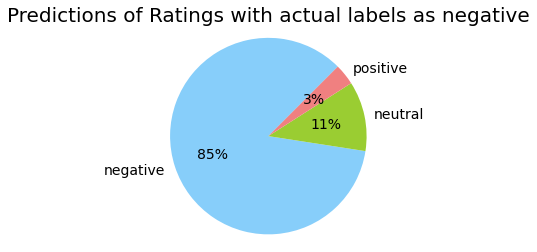

In [35]:
getPredictionOfActualLabels(cf,0,angle=45)


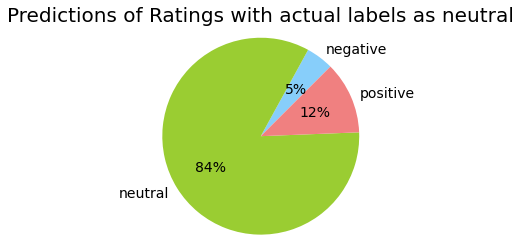

In [36]:
getPredictionOfActualLabels(cf,1,angle=45)

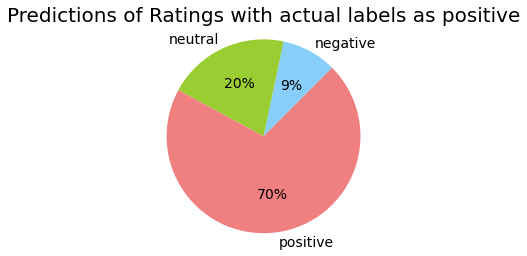

In [37]:
getPredictionOfActualLabels(cf,2,angle=45)

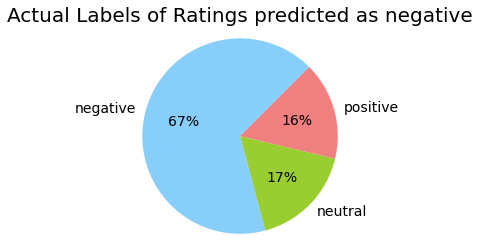

In [38]:
getActualLabelsOfPredictions(cf,0,angle=45)

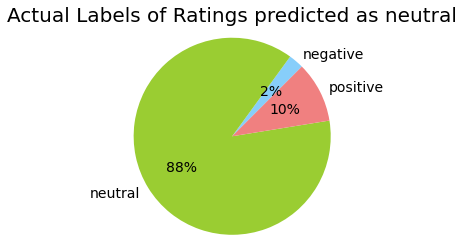

In [39]:
getActualLabelsOfPredictions(cf,1,angle=45)

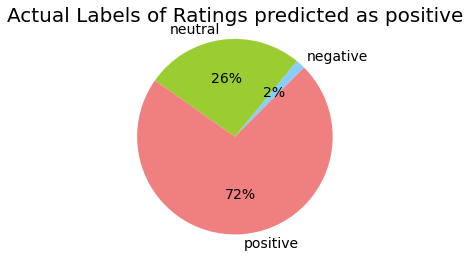

In [40]:
getActualLabelsOfPredictions(cf,2,angle=45)

In [41]:
import pickle

filenamedpcnn = '/content/drive/My Drive/content/BertAttnDPCNN5_colab_attention_False_finance_Exp7DPCNN.pkl'
filenamebert = '/content/drive/My Drive/content/BertAttnDPCNN5_colab_attention_False_finance_Exp7BERT.pkl'
pickle.dump(bert, open(filenamebert, 'wb'))
pickle.dump(dpcnn, open(filenamedpcnn, 'wb'))

In [42]:
import pickle
file = '/content/drive/My Drive/content/BertAttnDPCNN5_colab_attention_False_finance_maplist.pkl'
pickle.dump(dpcnn.maps, open(file, 'wb'))